In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import tensorflow as tf
from tensorflow import keras

In [29]:
# example use-case of np.where
a = np.arange(10)
print(a)

# np.where(condition, satisfies condition = 1, do not satisfy condition = 0)
np.where(a<3, 1, 0)

[0 1 2 3 4 5 6 7 8 9]


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [30]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    # Repeats the same pattern at each period
    season_time = ((time + phase) % period / period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

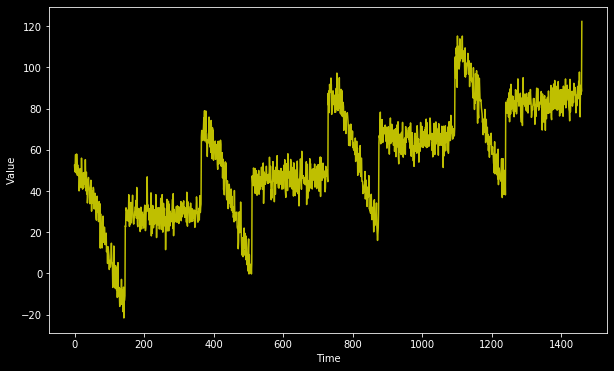

In [34]:
time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, series, format='y-')
plt.show()

- Now that we have the time series, let's split it so we can start forecasting

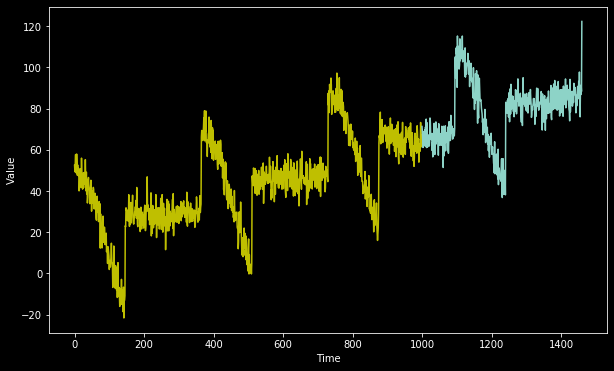

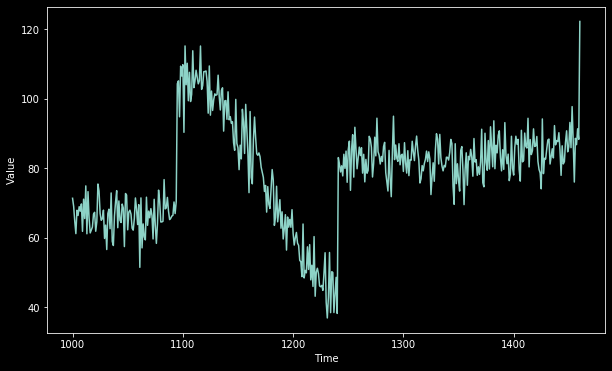

In [36]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10,6))
plot_series(time_train, x_train, format='y-')
plot_series(time_valid, x_valid)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [37]:
naive_forecast = series[split_time-1 : -1]

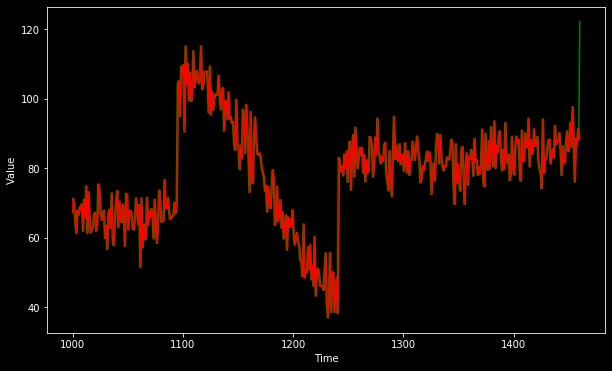

In [46]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, format='g-')
plot_series(time_valid, naive_forecast, format ='r-')

- Let's zoom in on the start of the validation period

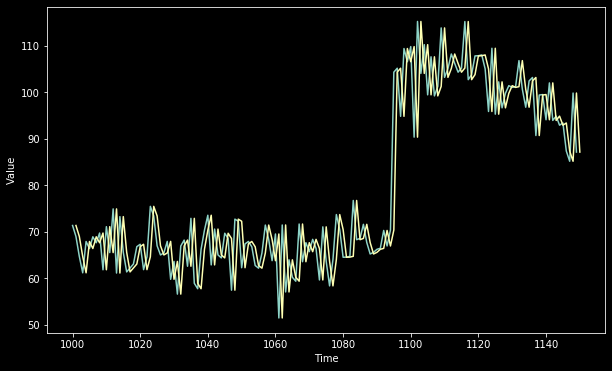

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

- Naive forecast lags 1 step behind the original time series
- Compute Mean Squared Error and the Mean Absolute Error between the forecasts and predictions in validation period

In [53]:
print('MSE:',keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print('MAE:',keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

MSE: 61.827526
MAE: 5.9379096


In [55]:
def moving_average_forecast(series, window_size):
    # Forecasts the mean of the last few values
    # If window_size = 1, then equivalent to naive forecast
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

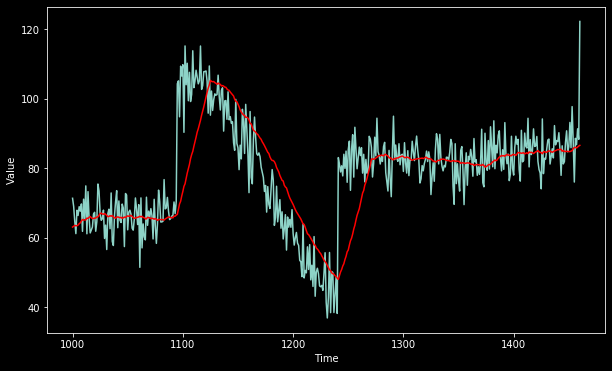

In [59]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg, format = 'r-')

In [60]:
print('MSE:', keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print('MAE:', keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

MSE: 106.6746
MAE: 7.142419


- That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t â€“ 365 from the value at time t.

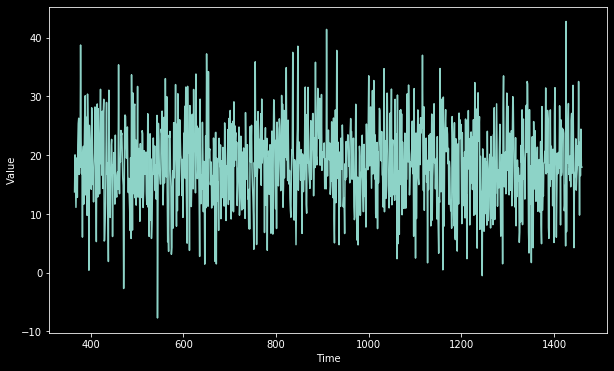

In [61]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series)
plt.show()

- The trend and seasonality seem to be gone, so now we can use the moving average

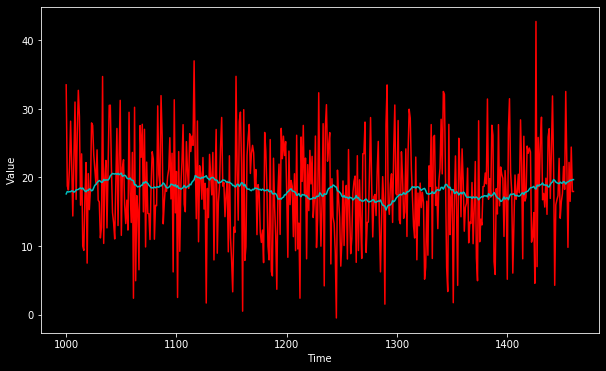

In [68]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time-365:], 'r-')
plot_series(time_valid, diff_moving_avg, 'c-')
plt.show()

- Now let's bring back the trend and seasonability by adding the past values from t-365

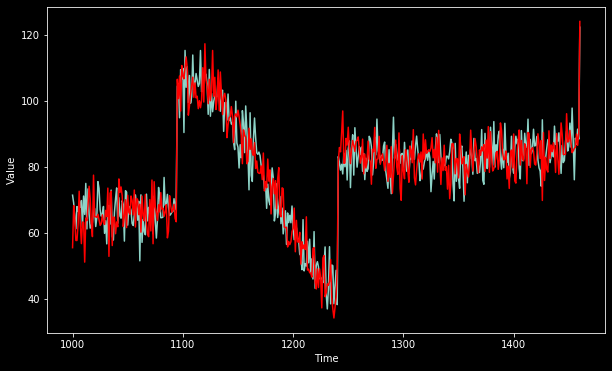

In [72]:
diff_moving_avg_plus_past = series[split_time - 365 : -365] + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past, 'r-')
plt.show()

In [73]:
print('MSE', keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print('MAE', keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

MSE 52.973675
MAE 5.8393106


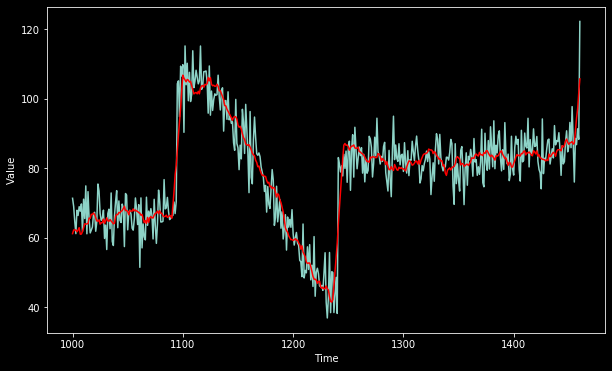

In [76]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370 : -360], 10) + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past, 'r-')
plt.show()

In [78]:
print('MSE:', keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print('MAE:', keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

MSE: 33.452267
MAE: 4.569442
